# Modelos de aprendizaje supervisado para predicción de  puntos y goles realizados después de cambio de entrenador.
En este cuaderno se realizaran los modelos de aprendizaje supervisado para la predicción de las siguientes dos variables:

-	“promedio_goles_hechos_despues_de_cambio_entrenador_1_5”
-	“puntos_hechos_despues_de_cambio_entrenador_1_5” \

Para la predicción de estas variables se utilizarán las siguientes 4 técnicas de aprendizaje supervisado:
-	RandomForest
-	DecisiónTree
-	AdaBoost
-	GradienBoosting 

Para cada variable se utilizarán los 4 modelos de aprendizaje.
Las características para realizar las predicciones se obtuvieron en el cuaderno llamado “Selección_caracteristicas_datasets_unificados”.
Como métricas de error se utilizarán el MAE y e MSE.



# Setting Preliminares

Iniciamos importando las librerías básicas que utilizaremos a lo largo del procesamiento de datos.

In [ ]:
# carga de datos
import pandas as pd
import io
from google.colab import files

# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
import seaborn as sns

import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from numpy import corrcoef, transpose, arange
from pylab import pcolor, show, colorbar, xticks, yticks

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
pd.options.mode.chained_assignment = None

# fechas
import datetime
import time



# Carga de Datos

Función de Google Colab para cargar datos.

In [ ]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

In [ ]:
#cargar
#europa_promedio_goles_fifa.csv
europa_promedio_goles = upload_files() 
europa_promedio_goles

Saving europa_promedio_goles_fifa.csv to europa_promedio_goles_fifa.csv
User uploaded file "europa_promedio_goles_fifa.csv" with length 696898 bytes


,jornada,fecha,puntos_actuales,equipo,liga,entrenador_nuevo,promedio_goles_hechos_antes_de_cambio_entrenador_1_5,promedio_goles_hechos_despues_de_cambio_entrenador_1_5,promedio_goles_recibidos_antes_de_cambio_entrenador_1_5,promedio_goles_recibidos_despues_de_cambio_entrenador_1_5,...,puntos_hechos_despues_de_cambio_entrenador_1_5,porcentaje_victorias_despues_de_cambio_entrenador_1_5,porcentaje_victorias_antes_de_cambio_entrenador_1_5,porcentaje_empates_despues_de_cambio_entrenador_1_5,porcentaje_empates_antes_de_cambio_entrenador_1_5,porcentaje_derrotas_despues_de_cambio_entrenador_1_5,porcentaje_derrotas_antes_de_cambio_entrenador_1_5,ataque,medio,defensa
0,1,09-08-2009,1,SC Freiburg,bundesliga,Robin Dutt,1.4,0.800000,2.8,2.400000,...,4,0.2,0.0,0.2,0.2,0.6,0.8,69.0,69.0,69.0
1,1,06-08-2011,1,SC Freiburg,bundesliga,Marcus Sorg,0.6,1.800000,1.8,3.200000,...,4,0.2,0.2,0.2,0.0,0.6,0.8,69.0,69.0,69.0
2,18,21-01-2012,16,SC Freiburg,bundesliga,Christian Streich,1.0,1.200000,2.4,1.600000,...,5,0.2,0.0,0.4,0.6,0.4,0.4,69.0,69.0,69.0
3,1,26-08-2018,0,RB Leipzig,bundesliga,Ralf Rangnick,2.6,1.600000,2.4,1.600000,...,8,0.4,0.4,0.4,0.2,0.2,0.4,78.0,78.0,78.0
4,1,18-08-2019,3,RB Leipzig,bundesliga,Julian Nagelsmann,1.6,2.600000,1.4,0.600000,...,13,0.8,0.4,0.2,0.4,0.0,0.2,80.0,80.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6020,32,01-04-2006,28,FC Messina,serie_a_italia,Gian Piero Ventura,0.8,0.800000,1.2,2.400000,...,3,0.2,0.2,0.0,0.2,0.8,0.6,71.0,71.0,71.0
6021,1,10-09-2006,3,FC Messina,serie_a_italia,Bruno Giordano,0.2,1.200000,2.4,0.800000,...,8,0.4,0.0,0.4,0.0,0.2,1.0,71.0,71.0,71.0
6022,23,11-02-2007,17,FC Messina,serie_a_italia,Alberto Cavasin,0.6,1.200000,2.2,1.200000,...,7,0.4,0.0,0.2,0.2,0.4,0.8,73.0,73.0,73.0
6023,31,07-04-2007,24,FC Messina,serie_a_italia,Bruno Giordano,0.8,0.666667,1.8,2.333333,...,0,0.0,0.2,0.0,0.2,1.0,0.6,73.0,73.0,73.0


Las estadísticas del Dataframe nos indican que el promedio de goles hechos en los 5 partidos después del cambio de entrenador es ligeramente más alto que el promedio de goles hechos en los 5 partidos antes del cambio de entrenador (Antes del cambio: 1.230882,Después del cambio: 1.293541), de hecho, este mismo efecto sucede con el promedio de goles recibidos(Antes del cambio :1.662061, Después del cambio: 1.460231), lo cual no indica que en promedio el efecto de cambio de entrenador no es despreciable.  

Reiniciamos el index de todos los datasets.

# **Modelos para predicciòn de puntos hechos despues de cambio de entrenador**

In [ ]:
selected_features = ['jornada','puntos_actuales','puntos_hechos_antes_de_cambio_entrenador_1_5','ataque']
selected_variable = 'puntos_hechos_despues_de_cambio_entrenador_1_5'

 Limpiar Outliers, normalizar y dividir Dataset en train y test.

In [ ]:
desc=europa_promedio_goles.describe()
desc

,jornada,puntos_actuales,promedio_goles_hechos_antes_de_cambio_entrenador_1_5,promedio_goles_hechos_despues_de_cambio_entrenador_1_5,promedio_goles_recibidos_antes_de_cambio_entrenador_1_5,promedio_goles_recibidos_despues_de_cambio_entrenador_1_5,puntos_hechos_antes_de_cambio_entrenador_1_5,puntos_hechos_despues_de_cambio_entrenador_1_5,porcentaje_victorias_despues_de_cambio_entrenador_1_5,porcentaje_victorias_antes_de_cambio_entrenador_1_5,porcentaje_empates_despues_de_cambio_entrenador_1_5,porcentaje_empates_antes_de_cambio_entrenador_1_5,porcentaje_derrotas_despues_de_cambio_entrenador_1_5,porcentaje_derrotas_antes_de_cambio_entrenador_1_5,ataque,medio,defensa
count,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000
mean,9.954523,11.007801,1.240055,1.314044,1.642324,1.432550,5.402324,5.947386,0.339101,0.278241,0.265604,0.245787,0.395295,0.475972,73.623402,73.623402,73.623402
std,10.789206,13.441814,0.671365,0.740391,0.674233,0.746915,3.207695,3.493124,0.261033,0.226571,0.232679,0.195444,0.276307,0.244891,7.727992,7.727992,7.727992
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,47.000000,47.000000
25%,1.000000,1.000000,0.800000,0.800000,1.200000,1.000000,3.000000,3.000000,0.200000,0.200000,0.000000,0.000000,0.200000,0.400000,68.000000,68.000000,68.000000
50%,3.000000,3.000000,1.200000,1.200000,1.600000,1.400000,5.000000,6.000000,0.400000,0.200000,0.200000,0.200000,0.400000,0.400000,73.000000,73.000000,73.000000
75%,18.000000,18.000000,1.600000,1.800000,2.000000,1.800000,7.000000,8.000000,0.500000,0.400000,0.400000,0.400000,0.600000,0.600000,79.000000,79.000000,79.000000
max,43.000000,91.000000,5.200000,9.000000,5.000000,9.000000,15.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,92.000000,92.000000,92.000000


Calcular valores de bigotes de cada variables

In [ ]:
#jornada
#bigote inferior
jornada_i=desc['jornada'][4] - 1.5 * (desc['jornada'][6]-desc['jornada'][4])
#bigote inferior
jornada_s=desc['jornada'][6] + 1.5 * (desc['jornada'][6]-desc['jornada'][4])

#puntos_actuales
#bigote inferior
puntos_actuales_i=desc['puntos_actuales'][4] - 1.5 * (desc['puntos_actuales'][6]-desc['puntos_actuales'][4])
#bigote inferior
puntos_actuales_s=desc['puntos_actuales'][6] + 1.5 * (desc['puntos_actuales'][6]-desc['puntos_actuales'][4])

#puntos_hechos_antes_de_cambio_entrenador_1_5
#bigote inferior
puntos_hechos_antes_de_cambio_entrenador_1_5_i=desc['puntos_hechos_antes_de_cambio_entrenador_1_5'][4] - 1.5 * (desc['puntos_hechos_antes_de_cambio_entrenador_1_5'][6]-desc['puntos_hechos_antes_de_cambio_entrenador_1_5'][4])
#bigote inferior
puntos_hechos_antes_de_cambio_entrenador_1_5_s=desc['puntos_hechos_antes_de_cambio_entrenador_1_5'][6] + 1.5 * (desc['puntos_hechos_antes_de_cambio_entrenador_1_5'][6]-desc['puntos_hechos_antes_de_cambio_entrenador_1_5'][4])

#ataque
#bigote inferior
ataque_i=desc['ataque'][4] - 1.5 * (desc['ataque'][6]-desc['ataque'][4])
#bigote inferior
ataque_s=desc['ataque'][6] + 1.5 * (desc['ataque'][6]-desc['ataque'][4])

#promedio_goles_hechos_despues_de_cambio_entrenador_1_5
#bigote inferior
puntos_hechos_despues_de_cambio_entrenador_1_5_i=desc['puntos_hechos_despues_de_cambio_entrenador_1_5'][4] - 1.5 * (desc['puntos_hechos_despues_de_cambio_entrenador_1_5'][6]-desc['puntos_hechos_despues_de_cambio_entrenador_1_5'][4])
#bigote inferior
puntos_hechos_despues_de_cambio_entrenador_1_5_s=desc['puntos_hechos_despues_de_cambio_entrenador_1_5'][6] + 1.5 * (desc['puntos_hechos_despues_de_cambio_entrenador_1_5'][6]-desc['puntos_hechos_despues_de_cambio_entrenador_1_5'][4])


In [ ]:
selected_variable_boxplot = [selected_variable]
selected_variable_boxplot

['puntos_hechos_despues_de_cambio_entrenador_1_5']

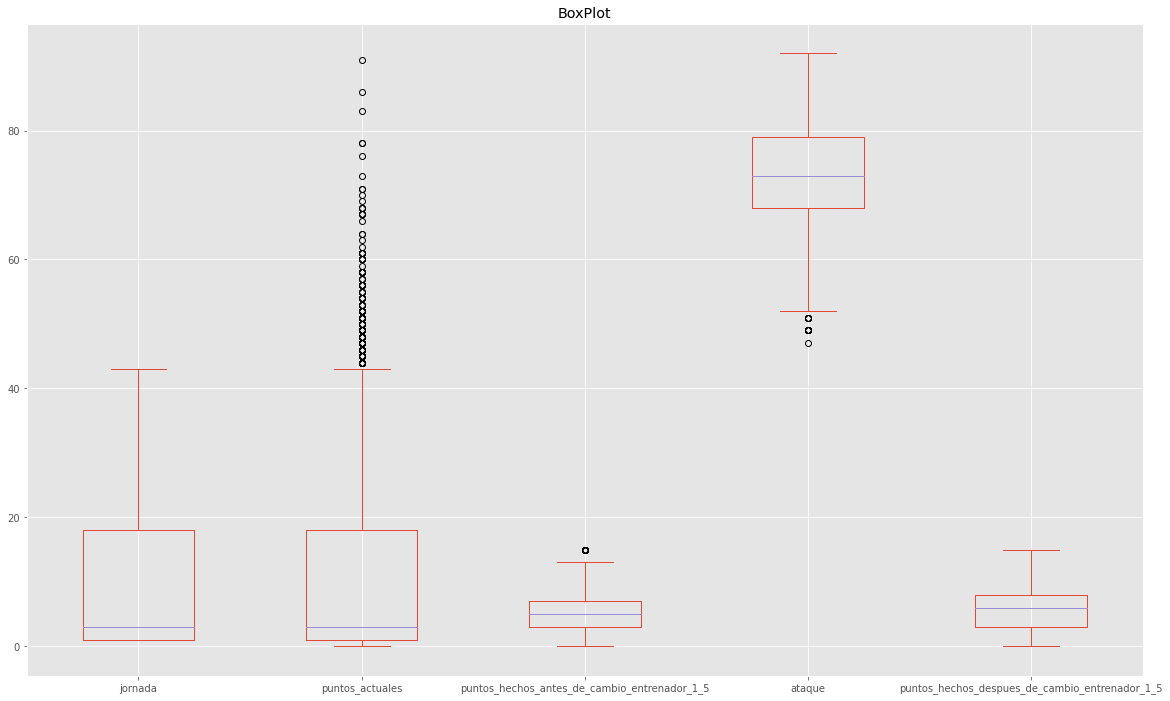

In [ ]:
europa_promedio_goles.plot(kind='box',y=(selected_features+selected_variable_boxplot),figsize=(20,12),title="BoxPlot")

In [ ]:
europa_promedio_goles_sin_outlier_2 = europa_promedio_goles[(europa_promedio_goles['jornada']<jornada_s) & (europa_promedio_goles['jornada']>jornada_i) &
                                                          (europa_promedio_goles['puntos_actuales']<puntos_actuales_s) & (europa_promedio_goles['puntos_actuales']>puntos_actuales_i) &
                                                          (europa_promedio_goles['promedio_goles_hechos_antes_de_cambio_entrenador_1_5']<promedio_goles_hechos_antes_de_cambio_entrenador_1_5_s) & (europa_promedio_goles['promedio_goles_hechos_antes_de_cambio_entrenador_1_5']>promedio_goles_hechos_antes_de_cambio_entrenador_1_5_i) &
                                                          (europa_promedio_goles['ataque']<ataque_s) & (europa_promedio_goles['ataque']>ataque_i) &
                                                          (europa_promedio_goles['promedio_goles_hechos_despues_de_cambio_entrenador_1_5']<promedio_goles_hechos_despues_de_cambio_entrenador_1_5_s) & (europa_promedio_goles['promedio_goles_hechos_despues_de_cambio_entrenador_1_5']>promedio_goles_hechos_despues_de_cambio_entrenador_1_5_i)]

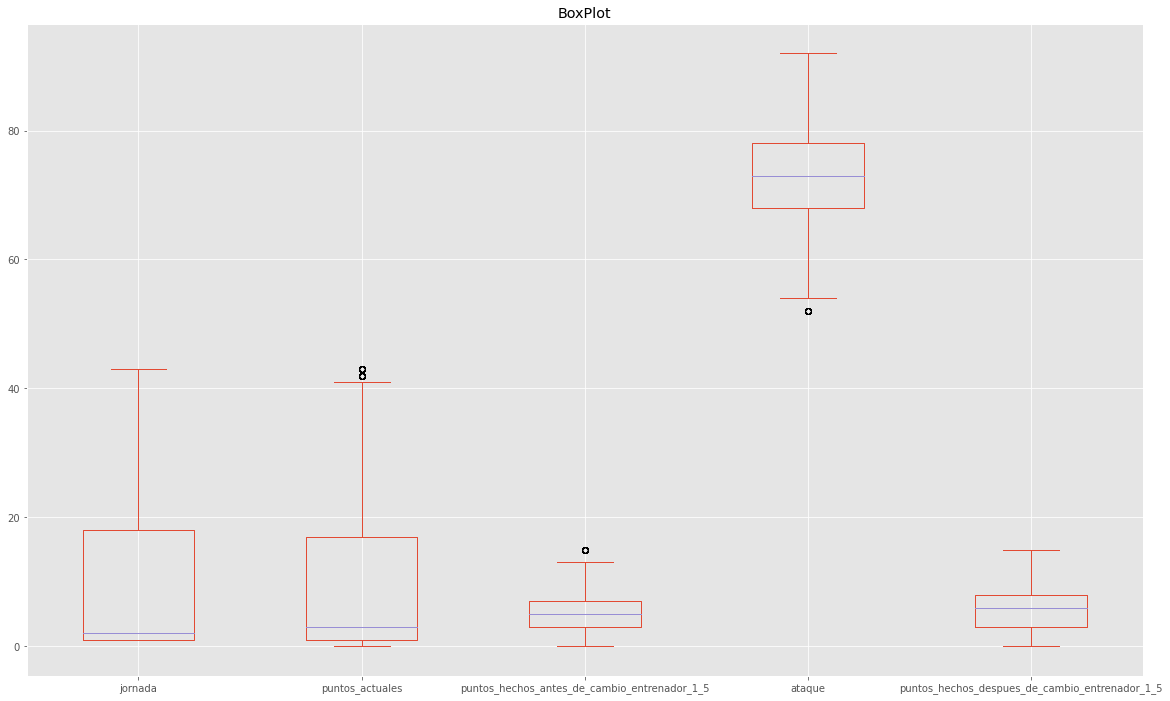

In [ ]:
europa_promedio_goles_sin_outlier_2.plot(kind='box',y=(selected_features+selected_variable_boxplot),figsize=(20,12),title="BoxPlot")

Separar variable objetivo.

In [ ]:
europa_promedio_goles_normalizado = europa_promedio_goles_sin_outlier_2[selected_features]
puntos_hechos_despues_de_cambio_entrenador_1_5 = europa_promedio_goles_sin_outlier_2[selected_variable]
puntos_hechos_despues_de_cambio_entrenador_1_5

0        4
1        4
2        5
3        8
4       13
        ..
6020     3
6021     8
6022     7
6023     0
6024     2
Name: puntos_hechos_despues_de_cambio_entrenador_1_5, Length: 5643, dtype: int64

Normalizar datos

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
scaler = MinMaxScaler()
europa_promedio_goles_normalizado[selected_features] = scaler.fit_transform(europa_promedio_goles_normalizado[selected_features])

In [ ]:
europa_promedio_goles_normalizado

,jornada,puntos_actuales,puntos_hechos_antes_de_cambio_entrenador_1_5,ataque
0,0.000000,0.023256,0.066667,0.425
1,0.000000,0.023256,0.200000,0.425
2,0.404762,0.372093,0.200000,0.425
3,0.000000,0.000000,0.466667,0.650
4,0.000000,0.069767,0.533333,0.700
...,...,...,...,...
6020,0.738095,0.651163,0.266667,0.475
6021,0.000000,0.069767,0.000000,0.475
6022,0.523810,0.395349,0.066667,0.525
6023,0.714286,0.558140,0.266667,0.525


In [ ]:
print(europa_promedio_goles_normalizado.max())
print(europa_promedio_goles_normalizado.min())

jornada                                         1.0
puntos_actuales                                 1.0
puntos_hechos_antes_de_cambio_entrenador_1_5    1.0
ataque                                          1.0
dtype: float64
jornada                                         0.0
puntos_actuales                                 0.0
puntos_hechos_antes_de_cambio_entrenador_1_5    0.0
ataque                                          0.0
dtype: float64


Unir columna sin normalizar al dataframe

In [ ]:
europa_promedio_goles_normalizado[selected_variable] = puntos_hechos_despues_de_cambio_entrenador_1_5
europa_promedio_goles_normalizado

,jornada,puntos_actuales,puntos_hechos_antes_de_cambio_entrenador_1_5,ataque,puntos_hechos_despues_de_cambio_entrenador_1_5
0,0.000000,0.023256,0.066667,0.425,4
1,0.000000,0.023256,0.200000,0.425,4
2,0.404762,0.372093,0.200000,0.425,5
3,0.000000,0.000000,0.466667,0.650,8
4,0.000000,0.069767,0.533333,0.700,13
...,...,...,...,...,...
6020,0.738095,0.651163,0.266667,0.475,3
6021,0.000000,0.069767,0.000000,0.475,8
6022,0.523810,0.395349,0.066667,0.525,7
6023,0.714286,0.558140,0.266667,0.525,0


Dividir dataframe "europa_promedio_goles_normalizado" en entreno con el 80% de los datos y testeo con el 20% de los datos de forma aleatoria

In [ ]:
p_train = 0.80 # Porcentaje de train.

entreno = europa_promedio_goles_normalizado[:int((len(europa_promedio_goles_normalizado))*p_train)] 
testeo = europa_promedio_goles_normalizado[int((len(europa_promedio_goles_normalizado))*p_train):]

print("Ejemplos usados para entrenar: ", len(entreno))
print("Ejemplos usados para test: ", len(testeo))

Ejemplos usados para entrenar:  4514
Ejemplos usados para test:  1129


Reiniciamos el index de todos los datasets.

In [ ]:
# reseteamos el index con el fin de evitar problemas en la validación cruzada
entreno.reset_index(drop = True, inplace = True)
testeo.reset_index(drop = True, inplace = True)

**Parametrización RandomForest** 

Repetimos el proceso de optimización  con las potencias del 2 hasta un máximo de 2 elevado a la 10.


In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits = 10, shuffle = True, random_state=0) # 

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:4

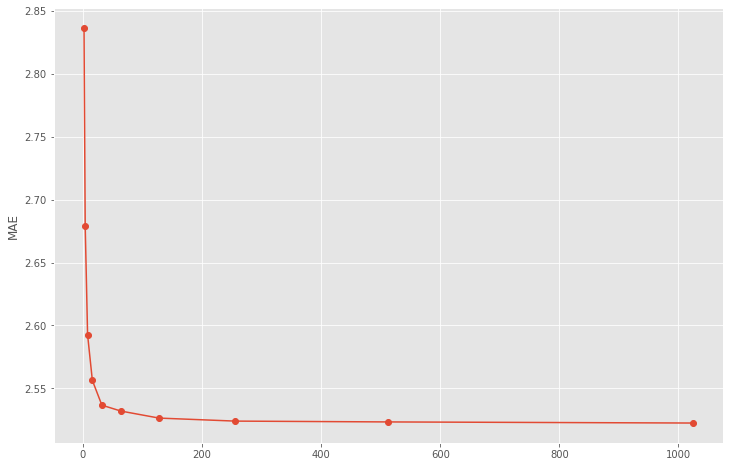

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  RandomForestRegressor(n_estimators= estimators, 
                  criterion='absolute_error', random_state=0)
   for train_fold, test_fold in cv.split(entreno):
      # División train test aleatoria
      f_train = entreno.loc[train_fold]
      f_test = entreno.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop([selected_variable], axis=1), 
                           y = f_train[selected_variable])
      y_pred = regressor.predict(X = f_test.drop([selected_variable], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test[selected_variable], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


  
plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show() 



In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 1024, MAE =   2.52)


** Implementacion del modelo Randomforest **



Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente.

In [ ]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error', 
                                   random_state=0)
# fit and predict

regressor.fit( X = entreno.drop([selected_variable], axis=1), y = entreno[selected_variable])
y_pred = regressor.predict(X = testeo.drop([selected_variable], axis = 1))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


Calculamos el mae obtenido.

In [ ]:
# mean absolute error
mae = mean_absolute_error(testeo[selected_variable], y_pred) 
print ('MAE', mae)

MAE 2.540327100863596


In [ ]:
# mean squared_error
from sklearn.metrics import mean_squared_error
mean_squared_error = mean_squared_error(testeo[selected_variable], y_pred) 
print ('mean_squared_error', mean_squared_error)

mean_squared_error 9.591361005713814


Por último probamos visualizamos como ha quedado nuestra predicción con la realidad.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


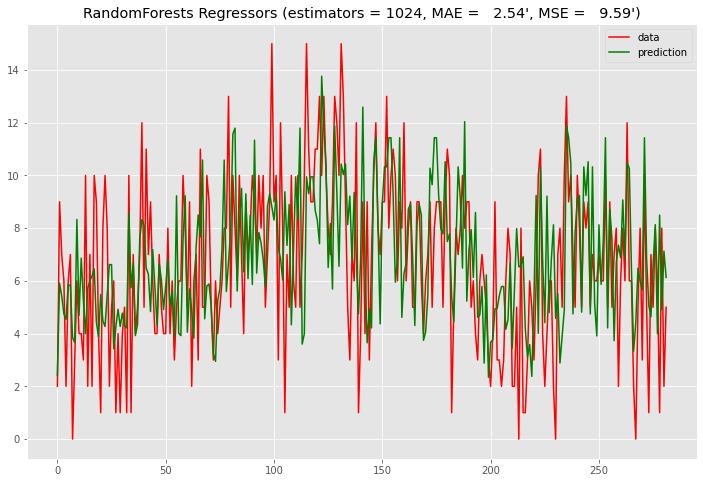

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(testeo[selected_variable][:(int(len(testeo)/4))].shape[0]))
plt.plot(xx, testeo[selected_variable][:(int(len(testeo)/4))], c='r', label='data')
plt.plot(xx, y_pred[:(int(len(testeo)/4))], c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f', MSE = %6.2f')" % (best_est, mae , mean_squared_error))

plt.show()

Relevancia de las características. 

In [ ]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
print(pd.DataFrame({'Attributes': (selected_features) ,
              'Decision Tree': regressor.feature_importances_}))

Feature Relevancies
                                     Attributes  Decision Tree
0                                       jornada       0.216637
1                               puntos_actuales       0.264847
2  puntos_hechos_antes_de_cambio_entrenador_1_5       0.228409
3                                        ataque       0.290107


**Parametrización Decision Tree**

Min Value 2.498328579048 (5)


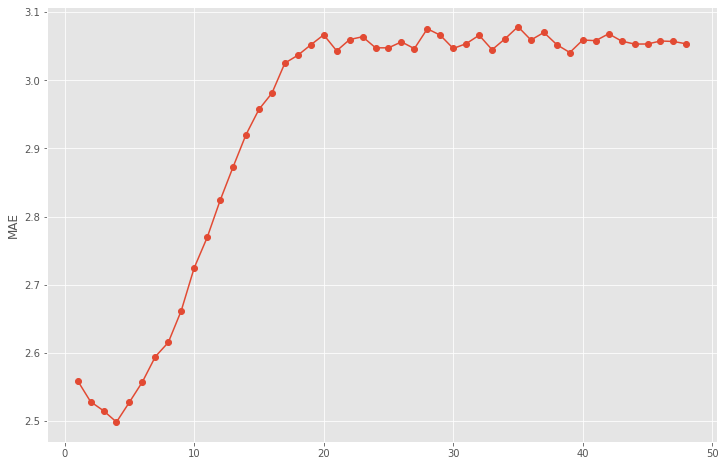

In [ ]:
# CROSS VALIDATION ANALYSIS
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold
cv = KFold(n_splits = 10, shuffle = True, random_state=0) # 

# reset index
entreno.reset_index(drop = True, inplace = True)
entreno.head()

total_scores = []
for i in range(2, 50):
   regressor = DecisionTreeRegressor(max_depth=i)
   fold_accuracy = []
   for train_fold, test_fold in cv.split(entreno):
      # División train test aleatoria
      f_train = entreno.loc[train_fold]
      f_test = entreno.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop([selected_variable], axis=1), 
                           y = f_train[selected_variable])
      y_pred = regressor.predict(X = f_test.drop([selected_variable], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test[selected_variable], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


max_depth = np.argmin(total_scores) + 2
print ('Min Value ' + str(min(total_scores)) +" (" + str(max_depth) + ")")

  
plt.plot(range(1,len(total_scores)+1), total_scores, 
         marker='o')
plt.ylabel('MAE')   

plt.show() 



**Parametrización AdaBoost**

In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits = 10, shuffle = True, random_state=0) # 

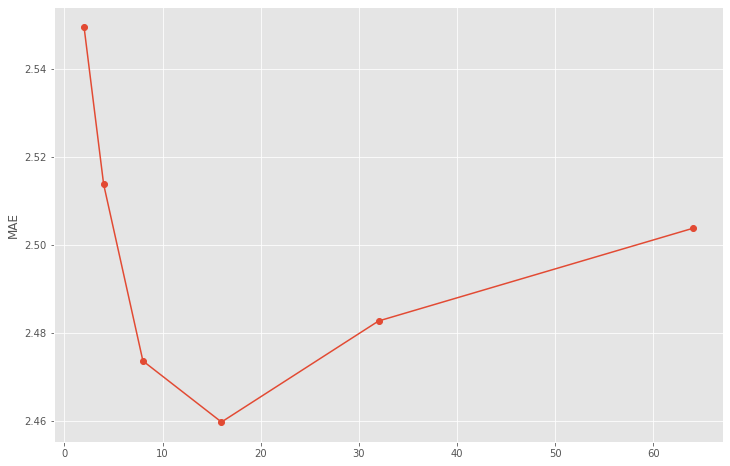

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

l_estimators = [2, 4, 8, 16, 32, 64,]# 128, 256, 512, 1024]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth, 
                                    criterion='absolute_error'),
                          n_estimators=estimators, random_state=0)
   for train_fold, test_fold in cv.split(entreno):
      # División train test aleatoria
      f_train = entreno.loc[train_fold]
      f_test = entreno.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop([selected_variable], axis=1), 
                           y = f_train[selected_variable])
      y_pred = regressor.predict(X = f_test.drop([selected_variable], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test[selected_variable], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


  
plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show() 



In [ ]:
best_est_AB = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est_AB, best_mae))

Min Value (estimators = 16, MAE =   2.46)


**Parametrización GradientBoosting**

In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits = 10, shuffle = True, random_state=0) # 

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/pyth

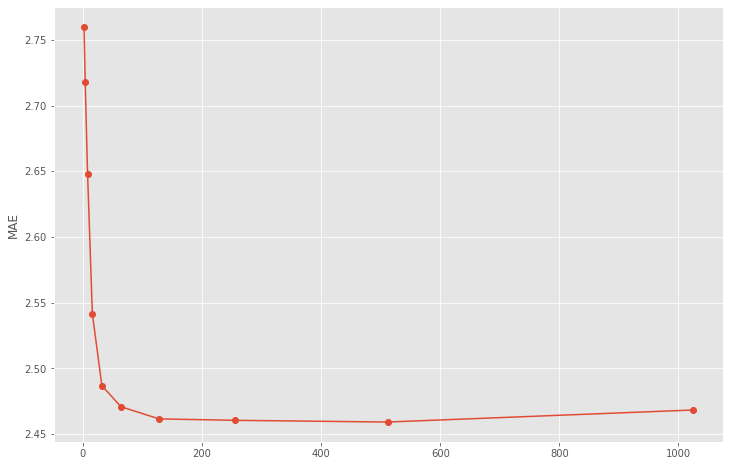

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  GradientBoostingRegressor(n_estimators=estimators, learning_rate=0.1, 
                                            random_state=0, loss='absolute_error',criterion='absolute_error')
   for train_fold, test_fold in cv.split(entreno):
      # División train test aleatoria
      f_train = entreno.loc[train_fold]
      f_test = entreno.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop([selected_variable], axis=1), 
                           y = f_train[selected_variable])
      y_pred = regressor.predict(X = f_test.drop([selected_variable], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test[selected_variable], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


  
plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show() 



In [ ]:
best_est_GB = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est_GB, best_mae))

Min Value (estimators = 512, MAE =   2.46)


**Implementación de modelos(Decision Tree, AdaBoost, GradientBoosting)**

Implementar los modelos Decision Tree y Boosting utilizando los parámetros obtenidos anteriormente.


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor



# Fit regression model
regressors = []
regressors.append(DecisionTreeRegressor(max_depth=max_depth, criterion='absolute_error'))
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth, 
                                    criterion='absolute_error'),
                          n_estimators=best_est_AB, random_state=0))
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py                         
regressors.append(GradientBoostingRegressor(n_estimators=best_est_GB, learning_rate=0.1, 
                                            random_state=0, loss='absolute_error',criterion='absolute_error'))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


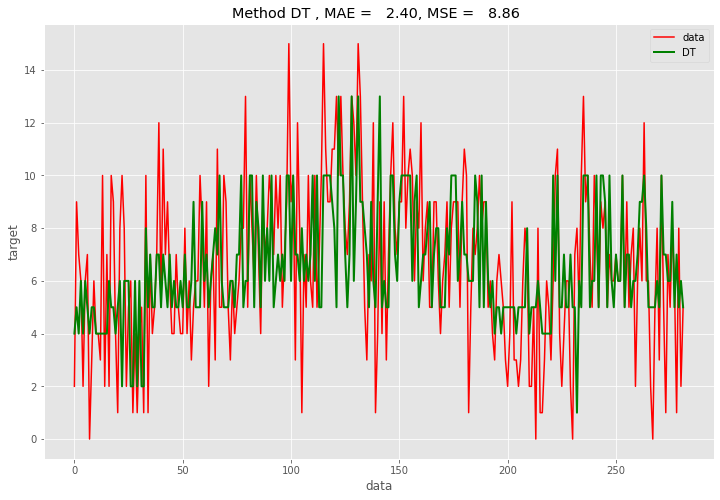

Feature Relevancies
                                     Attributes  Decision Tree
0                                       jornada       0.235132
1                               puntos_actuales       0.525881
2  puntos_hechos_antes_de_cambio_entrenador_1_5       0.052313
3                                        ataque       0.186674


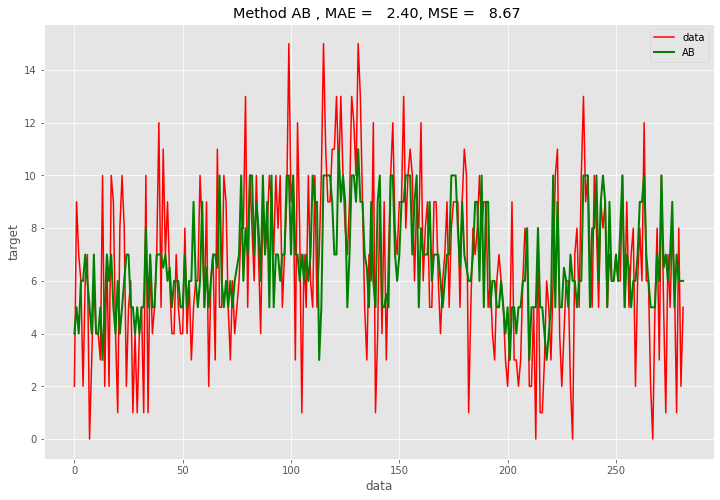

Feature Relevancies
                                     Attributes  Decision Tree
0                                       jornada       0.268230
1                               puntos_actuales       0.359110
2  puntos_hechos_antes_de_cambio_entrenador_1_5       0.133747
3                                        ataque       0.238913


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


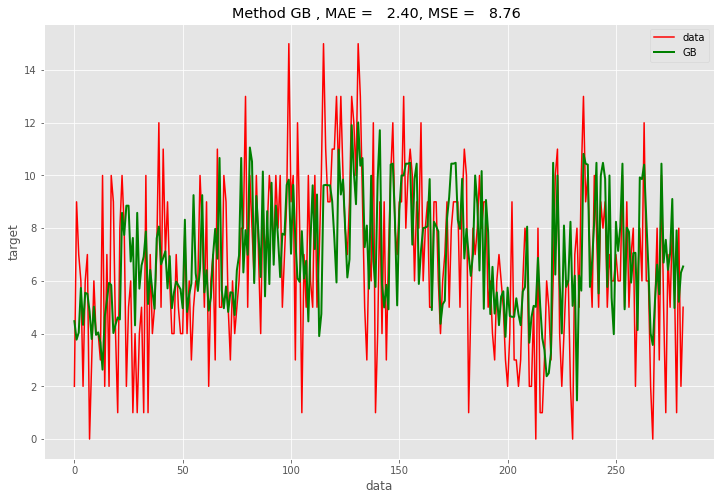

Feature Relevancies
                                     Attributes  Decision Tree
0                                       jornada       0.250907
1                               puntos_actuales       0.298988
2  puntos_hechos_antes_de_cambio_entrenador_1_5       0.154040
3                                        ataque       0.296066


In [ ]:
from sklearn.metrics import mean_squared_error
xx = np.stack(i for i in range(len(testeo[selected_variable][:(int(len(testeo)/4))])))
regr_names = ["DT", "AB", "GB"]

results = pd.DataFrame()
results['real'] = testeo[selected_variable]
               
for i, r in enumerate(regressors):
    from sklearn.metrics import mean_squared_error
    r.fit( X = entreno.drop([selected_variable], axis=1), y = entreno[selected_variable])
    y = r.predict(X = testeo.drop([selected_variable], axis = 1))
    results[regr_names[i]] = y
    mae = mean_absolute_error(testeo[selected_variable],y)
    mean_squared_error = mean_squared_error(testeo[selected_variable],y)
    # Plot the results
    plt.figure()
    plt.plot(xx, testeo[selected_variable][:(int(len(testeo)/4))], c='r', label='data')
    plt.plot(xx, y[:(int(len(testeo)/4))], c="g", label=regr_names[i], linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Method %s , MAE = %6.2f, MSE = %6.2f " % (regr_names[i], mae ,mean_squared_error))
    plt.axis('tight')
    plt.legend()
    plt.show()
    # FEATURE RELEVANCIES
    print ('Feature Relevancies')
    print(pd.DataFrame({'Attributes': (selected_features) ,
                  'Decision Tree': r.feature_importances_}))

# **Modelos para predicciòn de goles hechos despues de cambio de entrenador**

Seleccionar variable objetivo

In [ ]:
selected_features = ['jornada','puntos_actuales','promedio_goles_hechos_antes_de_cambio_entrenador_1_5','ataque']
selected_variable = 'promedio_goles_hechos_despues_de_cambio_entrenador_1_5'

Limpiar Outliers y normalizar y dividir Dataframe en train y test

In [ ]:
desc=europa_promedio_goles.describe()
desc

,jornada,puntos_actuales,promedio_goles_hechos_antes_de_cambio_entrenador_1_5,promedio_goles_hechos_despues_de_cambio_entrenador_1_5,promedio_goles_recibidos_antes_de_cambio_entrenador_1_5,promedio_goles_recibidos_despues_de_cambio_entrenador_1_5,puntos_hechos_antes_de_cambio_entrenador_1_5,puntos_hechos_despues_de_cambio_entrenador_1_5,porcentaje_victorias_despues_de_cambio_entrenador_1_5,porcentaje_victorias_antes_de_cambio_entrenador_1_5,porcentaje_empates_despues_de_cambio_entrenador_1_5,porcentaje_empates_antes_de_cambio_entrenador_1_5,porcentaje_derrotas_despues_de_cambio_entrenador_1_5,porcentaje_derrotas_antes_de_cambio_entrenador_1_5,ataque,medio,defensa
count,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000,6025.000000
mean,9.954523,11.007801,1.240055,1.314044,1.642324,1.432550,5.402324,5.947386,0.339101,0.278241,0.265604,0.245787,0.395295,0.475972,73.623402,73.623402,73.623402
std,10.789206,13.441814,0.671365,0.740391,0.674233,0.746915,3.207695,3.493124,0.261033,0.226571,0.232679,0.195444,0.276307,0.244891,7.727992,7.727992,7.727992
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,47.000000,47.000000
25%,1.000000,1.000000,0.800000,0.800000,1.200000,1.000000,3.000000,3.000000,0.200000,0.200000,0.000000,0.000000,0.200000,0.400000,68.000000,68.000000,68.000000
50%,3.000000,3.000000,1.200000,1.200000,1.600000,1.400000,5.000000,6.000000,0.400000,0.200000,0.200000,0.200000,0.400000,0.400000,73.000000,73.000000,73.000000
75%,18.000000,18.000000,1.600000,1.800000,2.000000,1.800000,7.000000,8.000000,0.500000,0.400000,0.400000,0.400000,0.600000,0.600000,79.000000,79.000000,79.000000
max,43.000000,91.000000,5.200000,9.000000,5.000000,9.000000,15.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,92.000000,92.000000,92.000000


Calcular valores de bigotes de cada variables

In [ ]:
#jornada
#bigote inferior
jornada_i=desc['jornada'][4] - 1.5 * (desc['jornada'][6]-desc['jornada'][4])
#bigote inferior
jornada_s=desc['jornada'][6] + 1.5 * (desc['jornada'][6]-desc['jornada'][4])

#puntos_actuales
#bigote inferior
puntos_actuales_i=desc['puntos_actuales'][4] - 1.5 * (desc['puntos_actuales'][6]-desc['puntos_actuales'][4])
#bigote inferior
puntos_actuales_s=desc['puntos_actuales'][6] + 1.5 * (desc['puntos_actuales'][6]-desc['puntos_actuales'][4])

#promedio_goles_hechos_antes_de_cambio_entrenador_1_5
#bigote inferior
promedio_goles_hechos_antes_de_cambio_entrenador_1_5_i=desc['promedio_goles_hechos_antes_de_cambio_entrenador_1_5'][4] - 1.5 * (desc['promedio_goles_hechos_antes_de_cambio_entrenador_1_5'][6]-desc['promedio_goles_hechos_antes_de_cambio_entrenador_1_5'][4])
#bigote inferior
promedio_goles_hechos_antes_de_cambio_entrenador_1_5_s=desc['promedio_goles_hechos_antes_de_cambio_entrenador_1_5'][6] + 1.5 * (desc['promedio_goles_hechos_antes_de_cambio_entrenador_1_5'][6]-desc['promedio_goles_hechos_antes_de_cambio_entrenador_1_5'][4])

#ataque
#bigote inferior
ataque_i=desc['ataque'][4] - 1.5 * (desc['ataque'][6]-desc['ataque'][4])
#bigote inferior
ataque_s=desc['ataque'][6] + 1.5 * (desc['ataque'][6]-desc['ataque'][4])

#promedio_goles_hechos_despues_de_cambio_entrenador_1_5
#bigote inferior
promedio_goles_hechos_despues_de_cambio_entrenador_1_5_i=desc['promedio_goles_hechos_despues_de_cambio_entrenador_1_5'][4] - 1.5 * (desc['promedio_goles_hechos_despues_de_cambio_entrenador_1_5'][6]-desc['promedio_goles_hechos_despues_de_cambio_entrenador_1_5'][4])
#bigote inferior
promedio_goles_hechos_despues_de_cambio_entrenador_1_5_s=desc['promedio_goles_hechos_despues_de_cambio_entrenador_1_5'][6] + 1.5 * (desc['promedio_goles_hechos_despues_de_cambio_entrenador_1_5'][6]-desc['promedio_goles_hechos_despues_de_cambio_entrenador_1_5'][4])


In [ ]:
selected_variable_boxplot = [selected_variable]
selected_variable_boxplot

['promedio_goles_hechos_despues_de_cambio_entrenador_1_5']

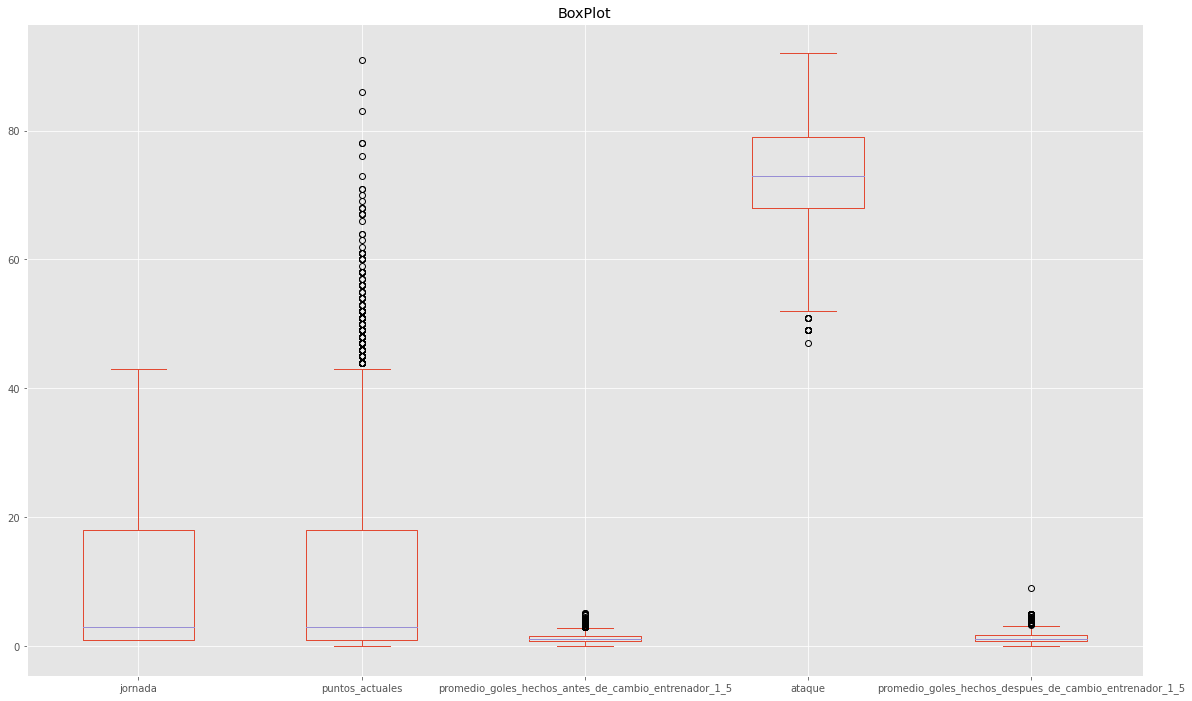

In [ ]:
europa_promedio_goles.plot(kind='box',y=(selected_features+selected_variable_boxplot),figsize=(20,12),title="BoxPlot")

In [ ]:
europa_promedio_goles_sin_outlier = europa_promedio_goles[(europa_promedio_goles['jornada']<jornada_s) & (europa_promedio_goles['jornada']>jornada_i) &
                                                          (europa_promedio_goles['puntos_actuales']<puntos_actuales_s) & (europa_promedio_goles['puntos_actuales']>puntos_actuales_i) &
                                                          (europa_promedio_goles['promedio_goles_hechos_antes_de_cambio_entrenador_1_5']<promedio_goles_hechos_antes_de_cambio_entrenador_1_5_s) & (europa_promedio_goles['promedio_goles_hechos_antes_de_cambio_entrenador_1_5']>promedio_goles_hechos_antes_de_cambio_entrenador_1_5_i) &
                                                          (europa_promedio_goles['ataque']<ataque_s) & (europa_promedio_goles['ataque']>ataque_i) &
                                                          (europa_promedio_goles['promedio_goles_hechos_despues_de_cambio_entrenador_1_5']<promedio_goles_hechos_despues_de_cambio_entrenador_1_5_s) & (europa_promedio_goles['promedio_goles_hechos_despues_de_cambio_entrenador_1_5']>promedio_goles_hechos_despues_de_cambio_entrenador_1_5_i)]

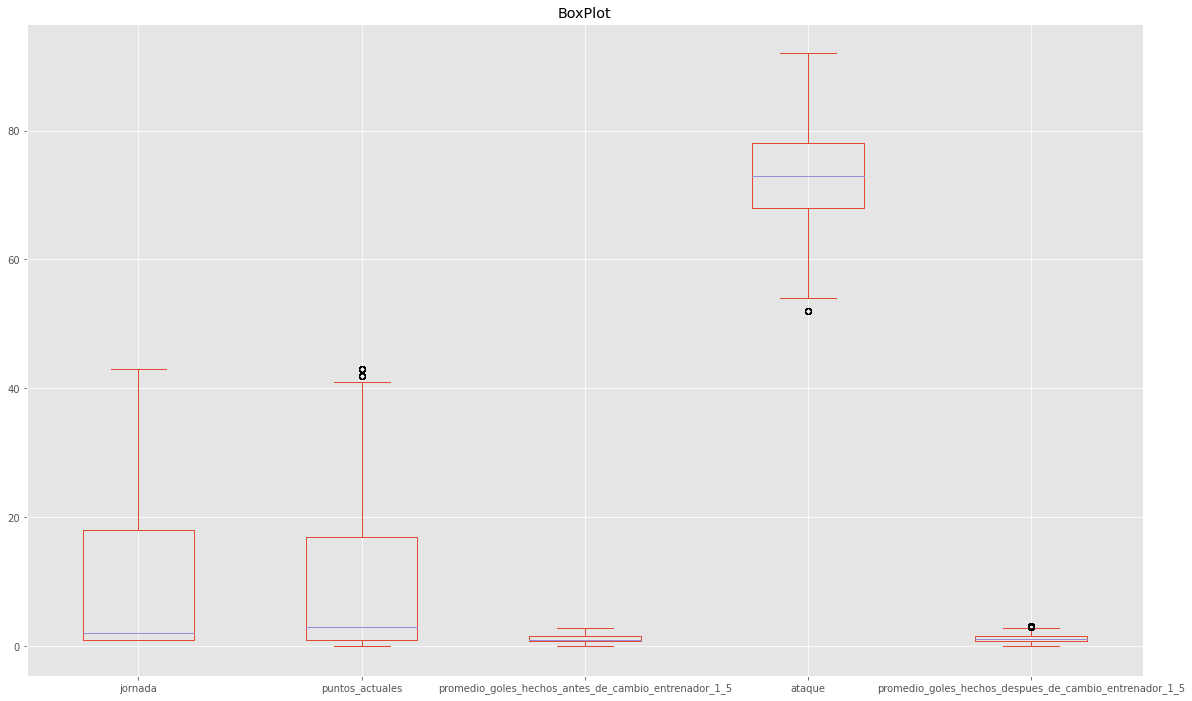

In [ ]:
europa_promedio_goles_sin_outlier.plot(kind='box',y=(selected_features+selected_variable_boxplot),figsize=(20,12),title="BoxPlot")

Separar columna de goles para ambos dataframe

In [ ]:
#europa_promedio_goles_normalizado
europa_promedio_goles_normalizado = europa_promedio_goles_sin_outlier[selected_features]
promedio_goles_hechos_despues_de_cambio_entrenador_1_5 = europa_promedio_goles_sin_outlier[selected_variable]
promedio_goles_hechos_despues_de_cambio_entrenador_1_5

0       0.800000
1       1.800000
2       1.200000
3       1.600000
4       2.600000
          ...   
6020    0.800000
6021    1.200000
6022    1.200000
6023    0.666667
6024    1.200000
Name: promedio_goles_hechos_despues_de_cambio_entrenador_1_5, Length: 5643, dtype: float64

Normalizar datos
Normalizamos los datos entre 0 y 1 para evitar que algunas variables con números muy grandes tengan mayor impacto, de esta manera todas las variables quedan en la misma escala.

In [ ]:
#europa_promedio_goles_1
from sklearn.preprocessing import MinMaxScaler
# performin min-max scaling each continuous feature column to the range [0, 1]
scaler = MinMaxScaler()
europa_promedio_goles_normalizado[selected_features] = scaler.fit_transform(europa_promedio_goles_normalizado[selected_features])

In [ ]:
europa_promedio_goles_normalizado

,jornada,puntos_actuales,promedio_goles_hechos_antes_de_cambio_entrenador_1_5,ataque
0,0.000000,0.023256,0.500000,0.425
1,0.000000,0.023256,0.214286,0.425
2,0.404762,0.372093,0.357143,0.425
3,0.000000,0.000000,0.928571,0.650
4,0.000000,0.069767,0.571429,0.700
...,...,...,...,...
6020,0.738095,0.651163,0.285714,0.475
6021,0.000000,0.069767,0.071429,0.475
6022,0.523810,0.395349,0.214286,0.525
6023,0.714286,0.558140,0.285714,0.525


Máximo y mínimo valor del Dataframe normalizado.

In [ ]:
print(europa_promedio_goles_normalizado.max())
print(europa_promedio_goles_normalizado.min())

jornada                                                 1.0
puntos_actuales                                         1.0
promedio_goles_hechos_antes_de_cambio_entrenador_1_5    1.0
ataque                                                  1.0
dtype: float64
jornada                                                 0.0
puntos_actuales                                         0.0
promedio_goles_hechos_antes_de_cambio_entrenador_1_5    0.0
ataque                                                  0.0
dtype: float64


Unir columna sin normalizar al dataframe correspondiente.





In [ ]:
# 1. unir variable objetivo sin normalizar a la primera division 
europa_promedio_goles_normalizado[selected_variable] = promedio_goles_hechos_despues_de_cambio_entrenador_1_5
europa_promedio_goles_normalizado

,jornada,puntos_actuales,promedio_goles_hechos_antes_de_cambio_entrenador_1_5,ataque,promedio_goles_hechos_despues_de_cambio_entrenador_1_5
0,0.000000,0.023256,0.500000,0.425,0.800000
1,0.000000,0.023256,0.214286,0.425,1.800000
2,0.404762,0.372093,0.357143,0.425,1.200000
3,0.000000,0.000000,0.928571,0.650,1.600000
4,0.000000,0.069767,0.571429,0.700,2.600000
...,...,...,...,...,...
6020,0.738095,0.651163,0.285714,0.475,0.800000
6021,0.000000,0.069767,0.071429,0.475,1.200000
6022,0.523810,0.395349,0.214286,0.525,1.200000
6023,0.714286,0.558140,0.285714,0.525,0.666667


Dividir dataframe "europa_promedio_goles_normalizado" en entreno con el 80% de los datos y testeo con el 20%.

In [ ]:
p_train = 0.80 # Porcentaje de train.

entreno = europa_promedio_goles_normalizado[:int((len(europa_promedio_goles_normalizado))*p_train)] 
testeo = europa_promedio_goles_normalizado[int((len(europa_promedio_goles_normalizado))*p_train):]

print("Ejemplos usados para entrenar: ", len(entreno))
print("Ejemplos usados para test: ", len(testeo))

Ejemplos usados para entrenar:  4514
Ejemplos usados para test:  1129


Reiniciamos el index de todos los datasets.

In [ ]:
# reseteamos el index con el fin de evitar problemas en la validación cruzada
entreno.reset_index(drop = True, inplace = True)
testeo.reset_index(drop = True, inplace = True)

**Parametrización RandomForest**

Vamos a optimizar el número de estimadores que probaremos con las potencias del 2 hasta un máximo de 2 elevado a la 10.


In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits = 10, shuffle = True, random_state=0) # 

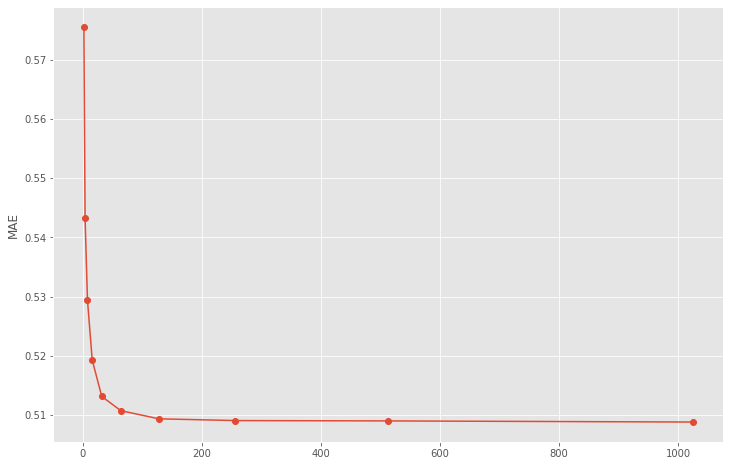

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  RandomForestRegressor(n_estimators= estimators, 
                  criterion='absolute_error', random_state=0)
   for train_fold, test_fold in cv.split(entreno):
      # División train test aleatoria
      f_train = entreno.loc[train_fold]
      f_test = entreno.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop([selected_variable], axis=1), 
                           y = f_train[selected_variable])
      y_pred = regressor.predict(X = f_test.drop([selected_variable], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test[selected_variable], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


  
plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show() 



In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 1024, MAE =   0.51)


**Implementacion del modelo Randomforest**


Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.


Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente.

In [ ]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error', 
                                   random_state=0)
# fit and predict

regressor.fit( X = entreno.drop([selected_variable], axis=1), y = entreno[selected_variable])
y_pred = regressor.predict(X = testeo.drop([selected_variable], axis = 1))

Calculamos el mae obtenido, para los datos de testeo y para la mitad del Dstaframe que guardamos para predecir el promedio de puntos obtenido despues del cambio de entrenador.

In [ ]:
# Mae testeo 
mae = mean_absolute_error(testeo[selected_variable], y_pred) 
print ('MAE', mae)

MAE 0.4970383010292111


In [ ]:
# mean squared_error
from sklearn.metrics import mean_squared_error
mean_squared_error = mean_squared_error(testeo[selected_variable], y_pred) 
print ('mean_squared_error', mean_squared_error)

mean_squared_error 0.39424127444362406


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


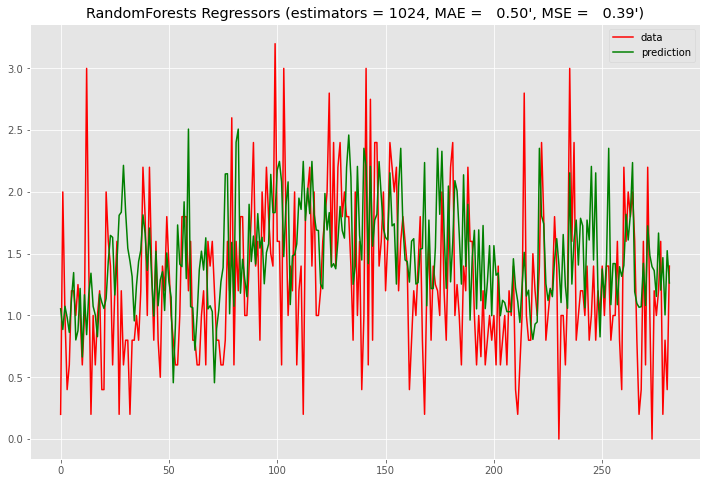

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(testeo[selected_variable][:(int(len(testeo)/4))].shape[0]))
plt.plot(xx, testeo[selected_variable][:(int(len(testeo)/4))], c='r', label='data')
plt.plot(xx, y_pred[:(int(len(testeo)/4))], c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f', MSE = %6.2f')" % (best_est, mae , mean_squared_error))

plt.show()

Podemos observar cuanta relevancia posee cada variable que se ha seleccionado para construir el modelo.

In [ ]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
print(pd.DataFrame({'Attributes': (selected_features) ,
              'Decision Tree': regressor.feature_importances_}))

Feature Relevancies
                                          Attributes  Decision Tree
0                                            jornada       0.209244
1                                    puntos_actuales       0.249507
2  promedio_goles_hechos_antes_de_cambio_entrenad...       0.225710
3                                             ataque       0.315539


Por último probamos visualizamos como ha quedado nuestra predicción con la realidad.

**Parametrización Decision Tree**

Min Value 0.4892799875985042 (4)


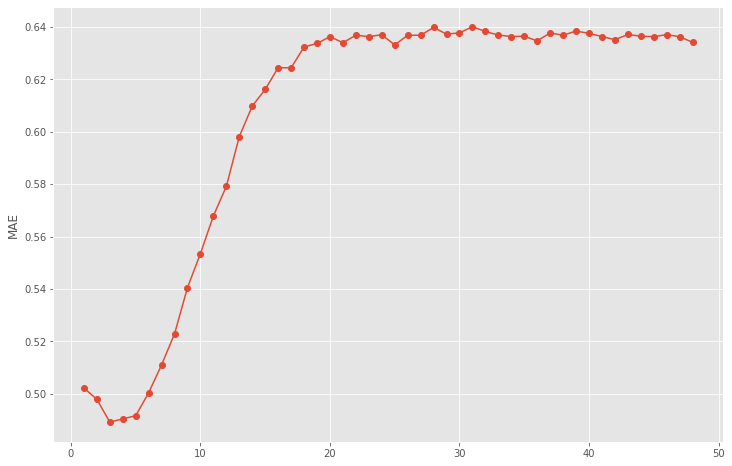

In [ ]:
# CROSS VALIDATION ANALYSIS
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold
cv = KFold(n_splits = 10, shuffle = True, random_state=0) # 

# reset index
entreno.reset_index(drop = True, inplace = True)
entreno.head()

total_scores = []
for i in range(2, 50):
   regressor = DecisionTreeRegressor(max_depth=i)
   fold_accuracy = []
   for train_fold, test_fold in cv.split(entreno):
      # División train test aleatoria
      f_train = entreno.loc[train_fold]
      f_test = entreno.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop([selected_variable], axis=1), 
                           y = f_train[selected_variable])
      y_pred = regressor.predict(X = f_test.drop([selected_variable], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test[selected_variable], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


max_depth = np.argmin(total_scores) + 2
print ('Min Value ' + str(min(total_scores)) +" (" + str(max_depth) + ")")

  
plt.plot(range(1,len(total_scores)+1), total_scores, 
         marker='o')
plt.ylabel('MAE')   

plt.show() 



**Parametrización AdaBoost**

In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits = 10, shuffle = True, random_state=0) # 

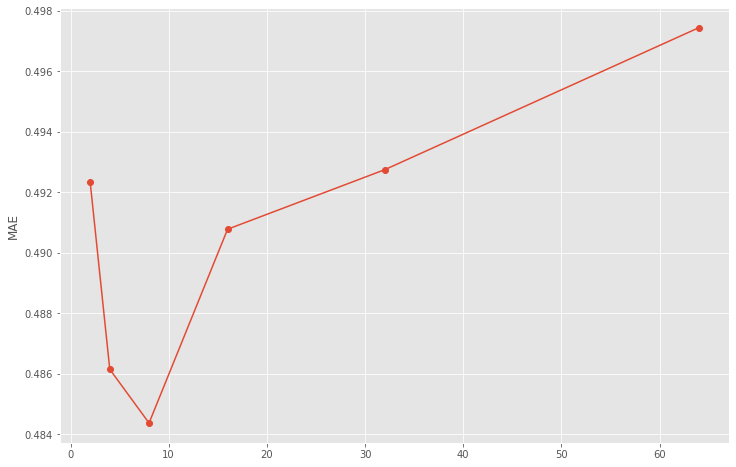

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

l_estimators = [2, 4, 8, 16, 32, 64,]# 128, 256, 512, 1024]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth, 
                                    criterion='absolute_error'),
                          n_estimators=estimators, random_state=0)
   for train_fold, test_fold in cv.split(entreno):
      # División train test aleatoria
      f_train = entreno.loc[train_fold]
      f_test = entreno.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop([selected_variable], axis=1), 
                           y = f_train[selected_variable])
      y_pred = regressor.predict(X = f_test.drop([selected_variable], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test[selected_variable], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


  
plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show() 



In [ ]:
best_est_AB = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est_AB, best_mae))

Min Value (estimators = 8, MAE =   0.48)


**Parametrización GradientBoosting**

In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits = 10, shuffle = True, random_state=0) # 

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/pyth

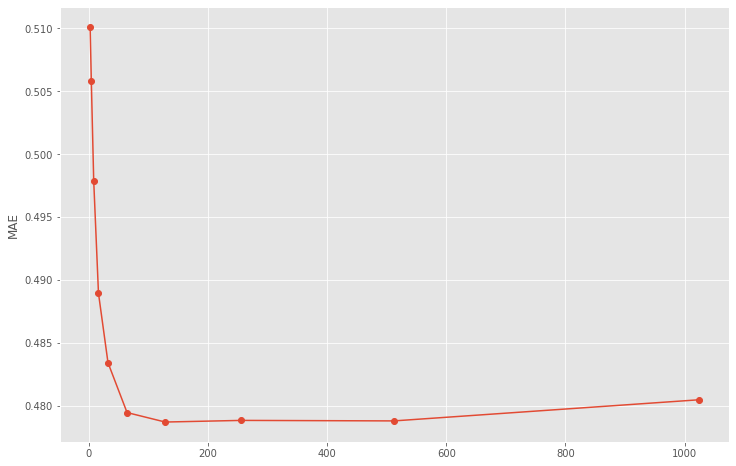

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  GradientBoostingRegressor(n_estimators=estimators, learning_rate=0.1, 
                                            random_state=0, loss='absolute_error',criterion='absolute_error')
   for train_fold, test_fold in cv.split(entreno):
      # División train test aleatoria
      f_train = entreno.loc[train_fold]
      f_test = entreno.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop([selected_variable], axis=1), 
                           y = f_train[selected_variable])
      y_pred = regressor.predict(X = f_test.drop([selected_variable], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test[selected_variable], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


  
plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
plt.show() 



In [ ]:
best_est_GB = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est_GB, best_mae))

Min Value (estimators = 128, MAE =   0.48)


**Implementación de modelos (Decision Tree, AdaBoost, GradientBoosting)**

Implementar los modelos Decision Tree y Boosting utilizando los parámetros obtenidos anteriormente.


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor



# Fit regression model
regressors = []
regressors.append(DecisionTreeRegressor(max_depth=max_depth, criterion='absolute_error'))
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth, 
                                    criterion='absolute_error'),
                          n_estimators=best_est_AB, random_state=0))
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py                         
regressors.append(GradientBoostingRegressor(n_estimators=best_est_GB, learning_rate=0.1, 
                                            random_state=0, loss='absolute_error',criterion='absolute_error'))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


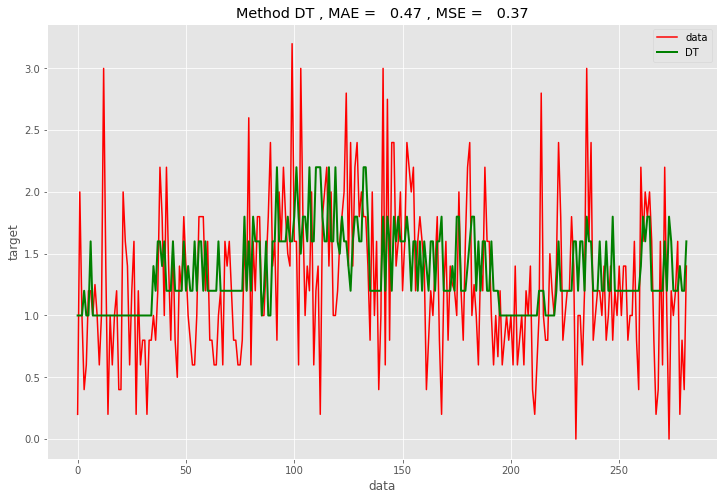

Feature Relevancies
                                          Attributes  Decision Tree
0                                            jornada       0.072275
1                                    puntos_actuales       0.174566
2  promedio_goles_hechos_antes_de_cambio_entrenad...       0.414100
3                                             ataque       0.339060


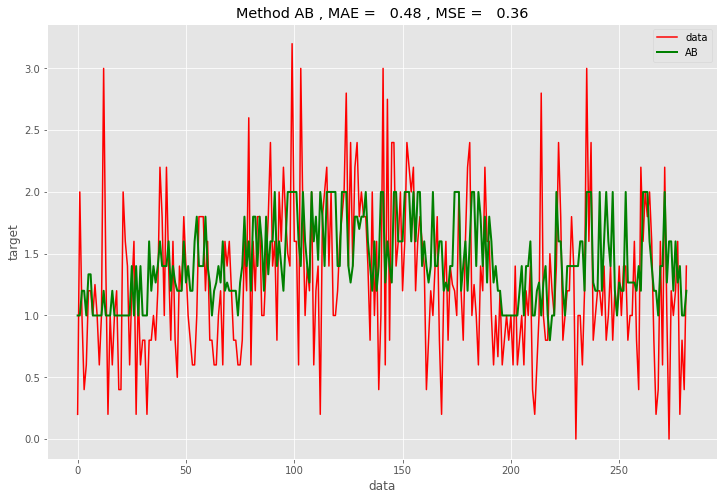

Feature Relevancies
                                          Attributes  Decision Tree
0                                            jornada       0.206894
1                                    puntos_actuales       0.336535
2  promedio_goles_hechos_antes_de_cambio_entrenad...       0.214479
3                                             ataque       0.242091


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1859: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


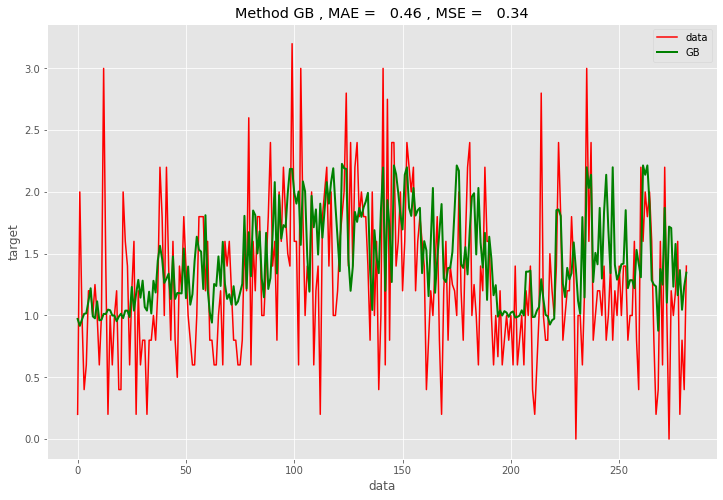

Feature Relevancies
                                          Attributes  Decision Tree
0                                            jornada       0.161425
1                                    puntos_actuales       0.293120
2  promedio_goles_hechos_antes_de_cambio_entrenad...       0.285012
3                                             ataque       0.260442


In [ ]:
from sklearn.metrics import mean_squared_error
xx = np.stack(i for i in range(len(testeo[selected_variable][:(int(len(testeo)/4))])))
regr_names = ["DT", "AB", "GB"]

results = pd.DataFrame()
results['real'] = testeo[selected_variable]
               
for i, r in enumerate(regressors):
    from sklearn.metrics import mean_squared_error
    r.fit( X = entreno.drop([selected_variable], axis=1), y = entreno[selected_variable])
    y = r.predict(X = testeo.drop([selected_variable], axis = 1))
    results[regr_names[i]] = y
    mae = mean_absolute_error(testeo[selected_variable],y)
    mean_squared_error = mean_squared_error(testeo[selected_variable],y)
    # Plot the results
    plt.figure()
    plt.plot(xx, testeo[selected_variable][:(int(len(testeo)/4))], c='r', label='data')
    plt.plot(xx, y[:(int(len(testeo)/4))], c="g", label=regr_names[i], linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Method %s , MAE = %6.2f , MSE = %6.2f"  % (regr_names[i], mae ,mean_squared_error))
    plt.axis('tight')
    plt.legend()
    plt.show()
    # FEATURE RELEVANCIES
    print ('Feature Relevancies')
    print(pd.DataFrame({'Attributes': (selected_features) ,
                  'Decision Tree': r.feature_importances_}))